# Scatter Plots
Collection of connectivity scatter plots (spontaneous + perturbed). Updated 7/27/17

In [1]:
### Import modules
import os
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

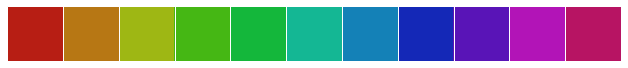

In [2]:
### Set color palette
import seaborn as sns
cp = sns.hls_palette(11, l=.4, s=.8)
sns.palplot(cp)
import matplotlib.gridspec as gridspec

In [3]:
### Set directory
os.chdir('/groups/turaga/home/kuperwajsi/bay_inf')

In [4]:
### Function to do upsampling by averaging two nearest bins
def upsampling_average(factor, data, columns, rows):
    data_upsampled = np.zeros((columns * factor, rows))
    for i in range(rows):
        counter = 0
        for y in range(columns-1):
            data_upsampled[counter,i] = data[y,i]
            data_upsampled[counter + 1,i] = (data[y,i] + data[y + 1,i]) / 2
            counter += 2
    return data_upsampled

### Function to do upsampling by setting to 0
def upsampling_zero(factor, data, columns, rows):
    data_upsampled = np.zeros((columns * factor, rows))
    for i in range(rows):
        counter = 0
        for y in range(columns-1):
            data_upsampled[counter,i] = data[y,i]
            data_upsampled[counter + 1,i] = 0
            counter += 2
    return data_upsampled

In [5]:
### Load clean data
clean_data = 'l161_clean.h5'
file = h5py.File(clean_data, 'r')

### Extract perturbations and fluorescent traces
traces_spont = file["spont/traces"].value/100
traces_photo = file["photo/traces"].value/100
traces_spont = (traces_spont - np.mean(traces_spont) + np.mean(traces_photo))*\
                   np.sqrt(np.var(traces_photo)/np.var(traces_spont))

## Preprocessing and Setup

In [6]:
g1 = tf.Graph()
g2 = tf.Graph()

with g1.as_default():
    from model_old import *
    saver.restore(sess, "./spont_full_upsampled/model_spont_full")
    
    ### Specify for spontaneous data
    stim_frames = np.array([], dtype=np.int32)
    stim_cells = np.array([0], dtype=np.int32)
    
    ### Set other useful variables
    T_total = traces_spont.shape[0]
    Nc = traces_spont.shape[1]
    Ns = np.max(stim_cells) + 1
    stim = np.zeros([T_total, Ns])
    stim_frames = np.ones([5, 1], dtype=np.int32) * np.transpose(stim_frames)
    stim[(stim_frames, stim_cells)] = 1
    
    upsample_factor = 2
    T_ = 40000
    Nb = 2
    Nl = 2
    
    ### Set correct dimensions for fluorescence and perturbations
    traces_spont_cut = traces_spont[0:T, :]
    perturbations_spont_cut = stim[0:T, :]
    
    traces_ups_cut = upsampling_average(upsample_factor, traces_spont_cut, T, Nc)
    perturbations_ups_cut = upsampling_zero(upsample_factor, perturbations_spont_cut, T, Ns)
    
    ### Recover the inferred spikes
    inferred_spikes_spont = sess.run(spikes.Q.mean(), feed_dict = {ca_raw_upsampled: traces_ups_cut, raw_inp_upsampled: perturbations_ups_cut})

    ### Recover the reconstructed fluorescent traces
    recon_spont = sess.run(calcium.Erecon, feed_dict = {ca_raw_upsampled: traces_ups_cut, raw_inp_upsampled: perturbations_ups_cut})

    ### Recover the connectivity
    connectivity_strength_spont = sess.run(Wglm.Qd.mean(), feed_dict = {ca_raw_upsampled: traces_ups_cut, raw_inp_upsampled: perturbations_ups_cut})
    connectivity_prob_spont = sess.run(Wglm.Qd.variance(), feed_dict = {ca_raw_upsampled: traces_ups_cut, raw_inp_upsampled: perturbations_ups_cut})
    
with g2.as_default():
    from model_old_pert import *
    saver_pert.restore(session, "./photo_full_upsampled/model_photo_full")
    
    ### Specify for perturbed data
    stim_frames = file["%(data)s/frames" % dm].value
    stim_cells  = file["%(data)s/types" % dm].value - 1

    ### Set other useful variables
    T_total = traces_photo.shape[0]
    Nc = traces_photo.shape[1]
    Ns = np.max(stim_cells) + 1
    stim = np.zeros([T_total, Ns])
    stim_frames = np.ones([5, 1], dtype=np.int32) * np.transpose(stim_frames)
    stim[(stim_frames, stim_cells)] = 1

    upsample_factor = 2
    T = 18000
    Nb = 2
    Nl = 2
    
    ### Set correct dimensions for fluorescence and perturbations
    traces_photo_cut = traces_photo[0:T, :]
    perturbations_photo_cut = stim[0:T, :]

    traces_ups_cut = upsampling_average(upsample_factor, traces_photo_cut, T, Nc)
    perturbations_ups_cut = upsampling_zero(upsample_factor, perturbations_photo_cut, T, Ns)
    
    ### Recover the inferred spikes
    inferred_spikes_pert = session.run(spikes.Q.mean(), feed_dict = {ca_raw_upsampled: traces_ups_cut, raw_inp_upsampled: perturbations_ups_cut})

    ### Recover the reconstructed fluorescent traces
    recon_pert = session.run(calcium.Erecon, feed_dict = {ca_raw_upsampled: traces_ups_cut, raw_inp_upsampled: perturbations_ups_cut})

    ### Recover the connectivity
    connectivity_strength_pert = session.run(Wglm.Qd.mean(), feed_dict = {ca_raw_upsampled: traces_ups_cut, raw_inp_upsampled: perturbations_ups_cut})
    connectivity_prob_pert = session.run(Wglm.Qd.variance(), feed_dict = {ca_raw_upsampled: traces_ups_cut, raw_inp_upsampled: perturbations_ups_cut})

INFO:tensorflow:Restoring parameters from ./spont_full_upsampled/model_spont_full
INFO:tensorflow:Restoring parameters from ./photo_full_upsampled/model_photo_full


## Compare Spontaneous + Perturbed Connections

In [7]:
### Function to plot scatter plots
def scatter_comp(x,y):
    plt.xlabel("Spontaneous")
    plt.ylabel("Perturbed")
    plt.scatter(x, y, s=1, c=cp[0], alpha=0.08)

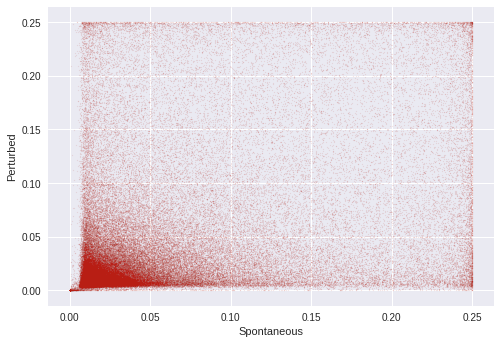

In [8]:
### Plot connection probabilities
scatter_comp(connectivity_prob_spont, connectivity_prob_pert)

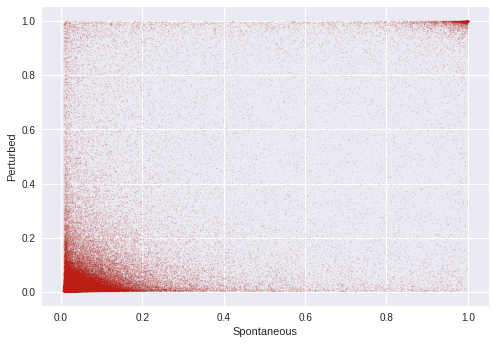

In [9]:
### Plot connection strengths
scatter_comp(connectivity_strength_spont, connectivity_strength_pert)

## Compare Connectivity with Correlation in Traces

In [7]:
### Calculate correlations for spontaneous calcium traces
spont_trace_correlations = np.zeros((348, 348))

for i in range(348):
    curr_neuron = traces_spont[:,i]
    for x in range(348):
        comp_neuron = traces_spont[:,x]
        corr_array = np.corrcoef(curr_neuron, comp_neuron)
        corr = corr_array[0,1]
        spont_trace_correlations[i,x] = corr

In [45]:
### Function to plot scatter plots for correlation
def scatter_comp_corr(x,y):
    #plt.xlabel("Spontaneous")
    plt.xlabel("Perturbed")
    plt.ylabel("Correlation")
    plt.scatter(x, y, s = .5, c=cp[2], alpha=0.1)

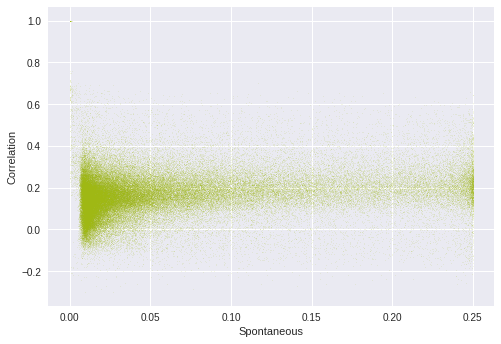

In [12]:
### Plot
scatter_comp_corr(connectivity_prob_spont, spont_trace_correlations)

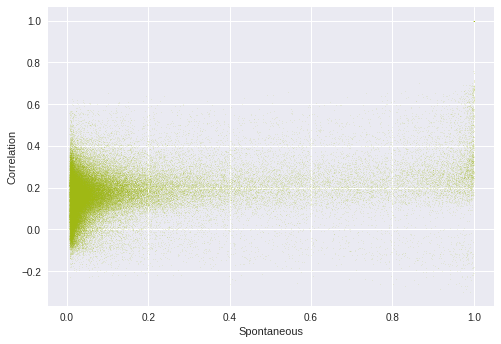

In [26]:
### Plot
scatter_comp_corr(connectivity_strength_spont, spont_trace_correlations)

In [8]:
### Calculate correlations for perturbed calcium traces
photo_trace_correlations = np.zeros((348, 348))

for i in range(348):
    curr_neuron = traces_photo[:,i]
    for x in range(348):
        comp_neuron = traces_photo[:,x]
        corr_array = np.corrcoef(curr_neuron, comp_neuron)
        corr = corr_array[0,1]
        photo_trace_correlations[i,x] = corr

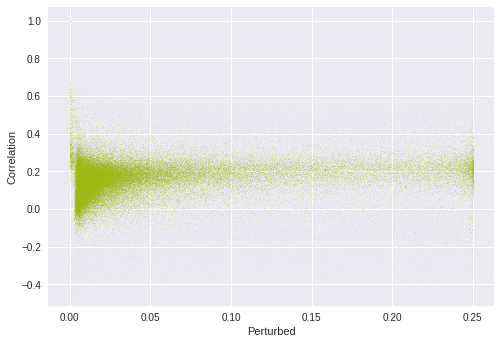

In [20]:
### Plot
scatter_comp_corr(connectivity_prob_pert, photo_trace_correlations)

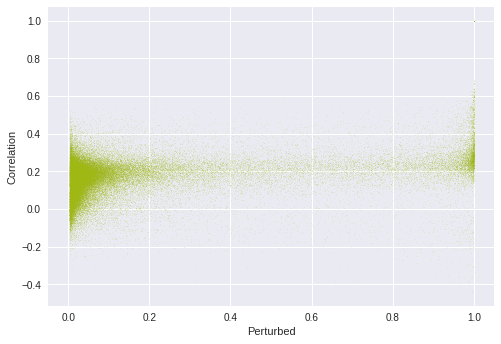

In [24]:
### Plot
scatter_comp_corr(connectivity_strength_pert, photo_trace_correlations)

In [107]:
### Function to plot scatter plots for correlation
def scatter_spont_pert(x_spont, y_spont, x_pert, y_pert, cp):
    fs = 12
    fig = plt.figure(figsize=(10, 15))
    gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
    ax1 = fig.add_subplot(gs[0])
    
    ax1.set_ylabel("Correlation", fontsize=fs + 2, y=0.5)
    ax1.set_xlabel("Connectivity", fontsize=fs + 2, y=0.5)
    ax1.scatter(x_spont, y_spont, s=.6, alpha=0.1, label="Spont", color=cp[0])
    ax1.scatter(x_pert, y_pert, s=.5, alpha=0.1, label="Pert", color=cp[2])

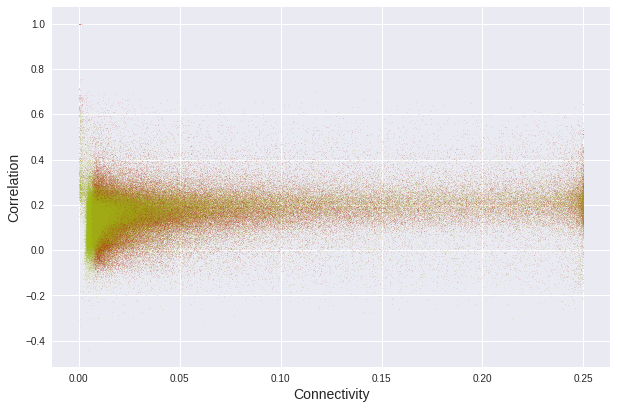

In [108]:
### Plot
scatter_spont_pert(connectivity_prob_spont, spont_trace_correlations, connectivity_prob_pert, photo_trace_correlations, cp)

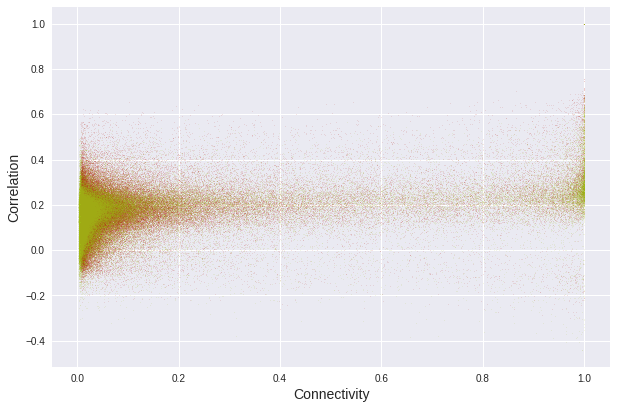

In [109]:
### Plot
scatter_spont_pert(connectivity_strength_spont, spont_trace_correlations, connectivity_strength_pert, photo_trace_correlations, cp)

## Compare Connectivity with Correlation in Inferred Spikes

In [27]:
### Calculate correlations for spontaneous inferred spikes
spont_spike_correlations = np.zeros((348, 348))

for i in range(348):
    curr_neuron = inferred_spikes_spont[:,i]
    for x in range(348):
        comp_neuron = inferred_spikes_spont[:,x]
        corr_array = np.corrcoef(curr_neuron, comp_neuron)
        corr = corr_array[0,1]
        spont_spike_correlations[i,x] = corr

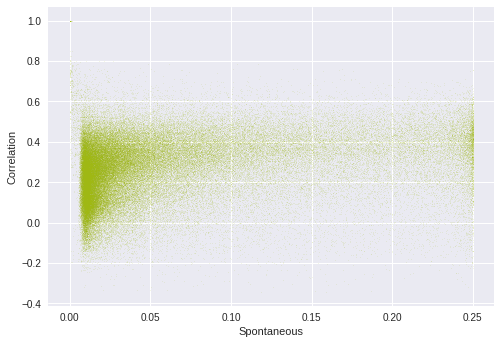

In [28]:
### Plot
scatter_comp_corr(connectivity_prob_spont, spont_spike_correlations)

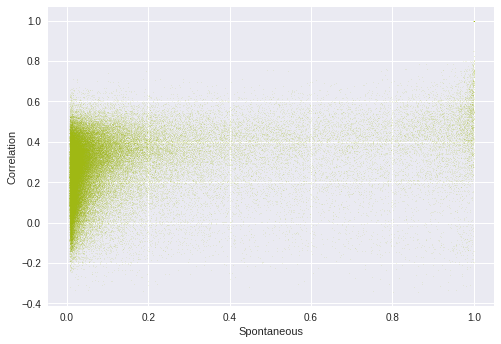

In [29]:
### Plot
scatter_comp_corr(connectivity_strength_spont, spont_spike_correlations)

In [31]:
### Calculate correlations for perturbed inferred spikes
photo_spike_correlations = np.zeros((348, 348))

for i in range(348):
    curr_neuron = inferred_spikes_pert[:,i]
    for x in range(348):
        comp_neuron = inferred_spikes_pert[:,x]
        corr_array = np.corrcoef(curr_neuron, comp_neuron)
        corr = corr_array[0,1]
        photo_spike_correlations[i,x] = corr

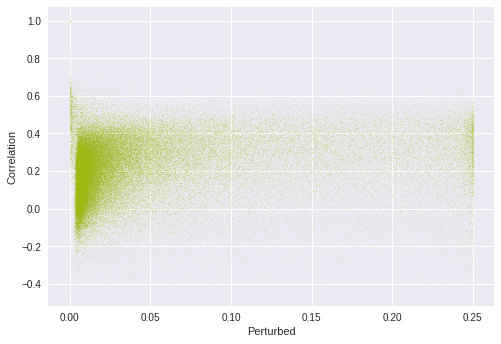

In [33]:
### Plot
scatter_comp_corr(connectivity_prob_pert, photo_spike_correlations)

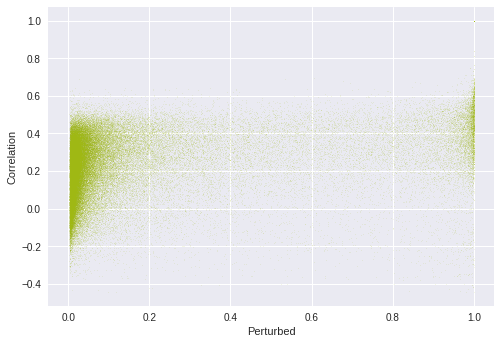

In [34]:
### Plot
scatter_comp_corr(connectivity_strength_pert, photo_spike_correlations)

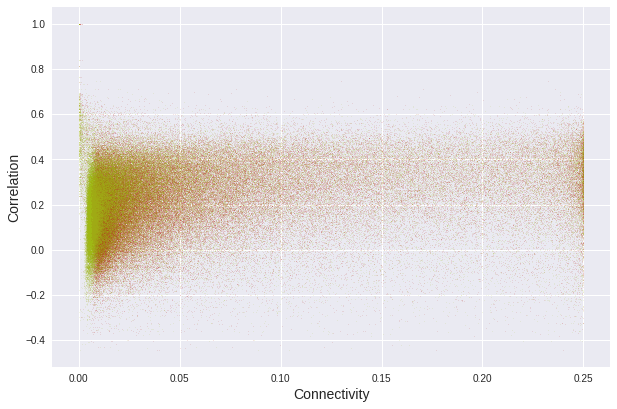

In [110]:
### Plot
scatter_spont_pert(connectivity_prob_spont, photo_spike_correlations, connectivity_prob_pert, photo_spike_correlations, cp)

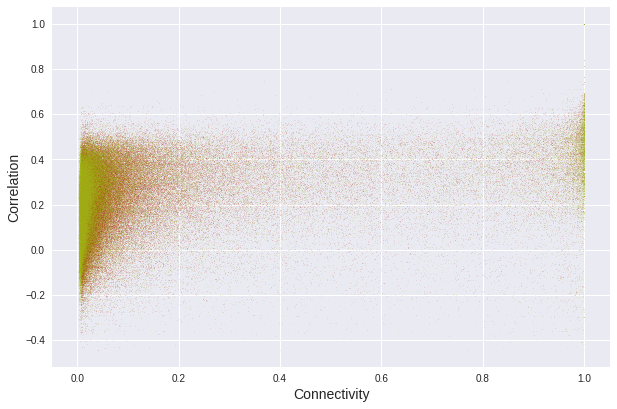

In [111]:
### Plot
scatter_spont_pert(connectivity_strength_spont, photo_spike_correlations, connectivity_strength_pert, photo_spike_correlations, cp)

## Compare Connectivity with Correlation in Reconstructions

In [38]:
### Calculate correlations for spontaneous reconstructions
spont_recon_correlations = np.zeros((348, 348))

for i in range(348):
    curr_neuron = recon_spont[:,i]
    for x in range(348):
        comp_neuron = recon_spont[:,x]
        corr_array = np.corrcoef(curr_neuron, comp_neuron)
        corr = corr_array[0,1]
        spont_recon_correlations[i,x] = corr

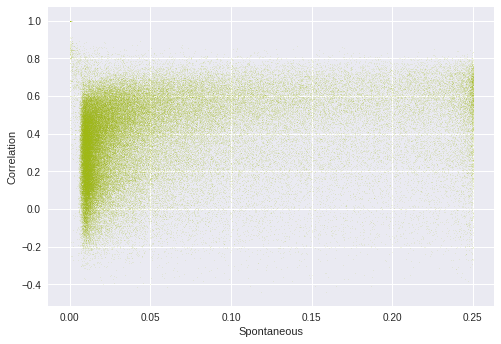

In [41]:
### Plot
scatter_comp_corr(connectivity_prob_spont, spont_recon_correlations)

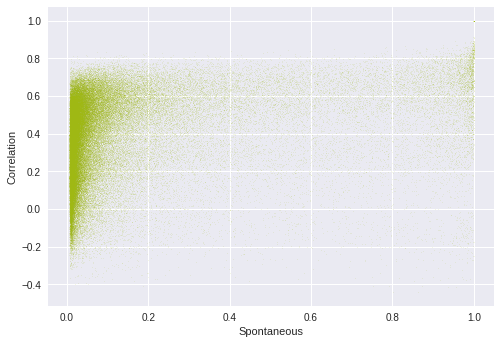

In [42]:
### Plot
scatter_comp_corr(connectivity_strength_spont, spont_recon_correlations)

In [39]:
### Calculate correlations for spontaneous reconstructions
photo_recon_correlations = np.zeros((348, 348))

for i in range(348):
    curr_neuron = recon_pert[:,i]
    for x in range(348):
        comp_neuron = recon_pert[:,x]
        corr_array = np.corrcoef(curr_neuron, comp_neuron)
        corr = corr_array[0,1]
        photo_recon_correlations[i,x] = corr

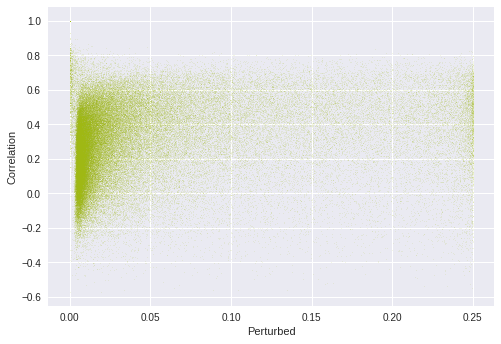

In [46]:
### Plot
scatter_comp_corr(connectivity_prob_pert, photo_recon_correlations)

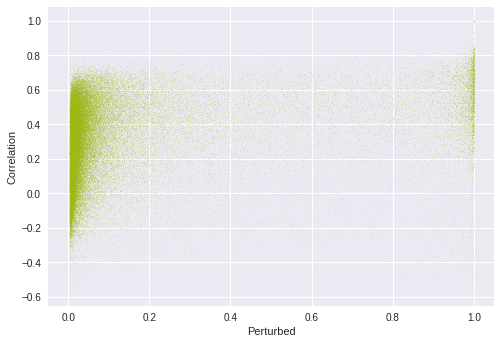

In [47]:
### Plot
scatter_comp_corr(connectivity_strength_pert, photo_recon_correlations)

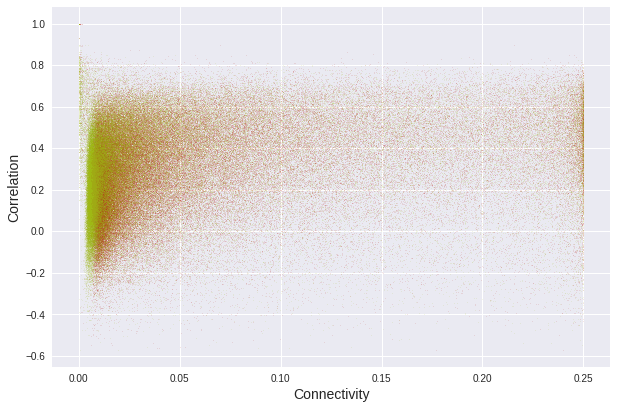

In [112]:
### Plot
scatter_spont_pert(connectivity_prob_spont, photo_recon_correlations, connectivity_prob_pert, photo_recon_correlations, cp)

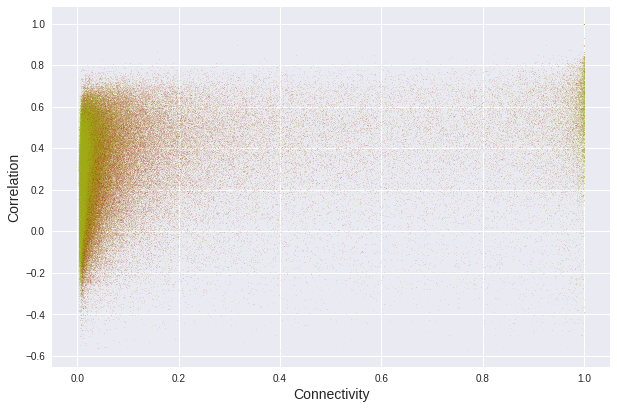

In [113]:
### Plot
scatter_spont_pert(connectivity_strength_spont, photo_recon_correlations, connectivity_strength_pert, photo_recon_correlations, cp)